
# Searchlight analysis of face vs house recognition

Searchlight analysis requires fitting a classifier a large amount of
times. As a result, it is an intrinsically slow method. In order to speed
up computing, in this example, Searchlight is run only on one slice on
the :term:`fMRI` (see the generated figures).

.. include:: ../../../examples/masker_note.rst


## Load Haxby dataset



In [1]:
import pandas as pd

from nilearn import datasets
from nilearn.image import get_data, load_img, new_img_like

# We fetch 2nd subject from haxby datasets (which is default)
haxby_dataset = datasets.fetch_haxby()

# print basic information on the dataset
print(f"Anatomical nifti image (3D) is located at: {haxby_dataset.mask}")
print(f"Functional nifti image (4D) is located at: {haxby_dataset.func[0]}")

fmri_filename = haxby_dataset.func[0]
labels = pd.read_csv(haxby_dataset.session_target[0], sep=" ")
y = labels["labels"]
run = labels["chunks"]

Anatomical nifti image (3D) is located at: /Users/evanwoods/nilearn_data/haxby2001/mask.nii.gz
Functional nifti image (4D) is located at: /Users/evanwoods/nilearn_data/haxby2001/subj2/bold.nii.gz


## Restrict to faces and houses



In [2]:
from nilearn.image import index_img

condition_mask = y.isin(["face", "house"])

fmri_img = index_img(fmri_filename, condition_mask)
y, run = y[condition_mask], run[condition_mask]

## Prepare masks
- mask_img is the original mask
- process_mask_img is a subset of mask_img, it contains the voxels that
  should be processed (we only keep the slice z = 29 and the back of the
  brain to speed up computation)



In [3]:
import numpy as np

mask_img = load_img(haxby_dataset.mask)

# .astype() makes a copy.
process_mask = get_data(mask_img).astype(int)
picked_slice = 29
process_mask[..., (picked_slice + 1) :] = 0
process_mask[..., :picked_slice] = 0
process_mask[:, 30:] = 0
process_mask_img = new_img_like(mask_img, process_mask)

/var/folders/km/lr9wgyjj0z737tmwxblc5d980000gn/T/ipykernel_8468/1127590685.py:11: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


## Searchlight computation



In [4]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.
n_jobs = 2

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the run, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets
from sklearn.model_selection import KFold

cv = KFold(n_splits=4)

import nilearn.decoding

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = nilearn.decoding.SearchLight(
    mask_img,
    process_mask_img=process_mask_img,
    radius=5.6,
    n_jobs=n_jobs,
    verbose=1,
    cv=cv,
)
searchlight.fit(fmri_img, y)

/Volumes/T7/Github/Searchlight-analysis-of-face-vs-house-recognition/py_env_nilearn/lib/python3.11/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
/Volumes/T7/Github/Searchlight-analysis-of-face-vs-house-recognition/py_env_nilearn/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Volumes/T7/Github/Searchlight-analysis-of-face-vs-house-recognition/py_env_nilearn/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Volumes/T7/Github/Searchlight-analysis-of-face-vs-house-recognition/py_env_nilearn/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWar

SearchLight(cv=KFold(n_splits=4, random_state=None, shuffle=False),
            mask_img=<nibabel.nifti1.Nifti1Image object at 0x125203950>,
            n_jobs=2,
            process_mask_img=<nibabel.nifti1.Nifti1Image object at 0x121edd050>,
            radius=5.6, verbose=1)

## F-scores computation



In [5]:
from nilearn.maskers import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(
    mask_img=mask_img,
    runs=run,
    standardize="zscore_sample",
    memory="nilearn_cache",
    memory_level=1,
)
fmri_masked = nifti_masker.fit_transform(fmri_img)

from sklearn.feature_selection import f_classif

_, p_values = f_classif(fmri_masked, y)
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = get_data(nifti_masker.inverse_transform(p_values))

/Volumes/T7/Github/Searchlight-analysis-of-face-vs-house-recognition/py_env_nilearn/lib/python3.11/site-packages/nilearn/image/resampling.py:492: UserWarning: The provided image has no sform in its header. Please check the provided file. Results may not be as expected.
  warnings.warn(


## Visualization
Use the :term:`fMRI` mean image as a surrogate of anatomical data



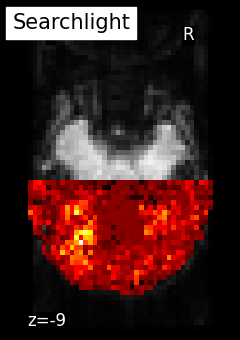

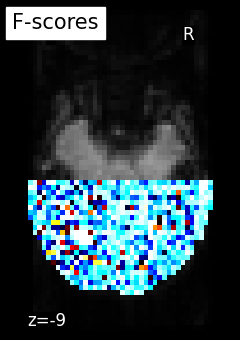

In [7]:
from nilearn import image

mean_fmri = image.mean_img(fmri_img)

from nilearn.plotting import plot_img, plot_stat_map, show

searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
plot_img(
    searchlight_img,
    bg_img=mean_fmri,
    title="Searchlight",
    display_mode="z",
    cut_coords=[-9],
    vmin=0.42,
    cmap="hot",
    threshold=0.2,
    black_bg=True,
)

# F_score results
p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
f_score_img = new_img_like(mean_fmri, p_ma)
plot_stat_map(
    f_score_img,
    mean_fmri,
    title="F-scores",
    display_mode="z",
    cut_coords=[-9],
    colorbar=False,
)

show()